# Energy Consumption Forecast using XGBoost Algorithm

### About the data 
**This dataset is from Kaggle**

**PJM Hourly Energy Consumption Data**

PJM Interconnection LLC (PJM) is a regional transmission organization (RTO) in the United States. It is part of the Eastern Interconnection grid operating an electric transmission system serving all or parts of Delaware, Illinois, Indiana, Kentucky, Maryland, Michigan, New Jersey, North Carolina, Ohio, Pennsylvania, Tennessee, Virginia, West Virginia, and the District of Columbia.

The hourly power consumption data comes from PJM's website and are in megawatts (MW).

The regions have changed over the years so data may only appear for certain dates per region.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [79]:
df = pd.read_csv("PJME_hourly.csv")
df

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0
...,...,...
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0


In [80]:
# Verifying the data type
df.dtypes

Datetime     object
PJME_MW     float64
dtype: object

**Datetime columns is object type, changing it to datetime type and setting the Datetime column as the index**

In [81]:
#df["Datetime"] = pd.to_datetime(df["Datetime"])
#df.dtypes

In [82]:
df = df.set_index("Datetime")
df.index = pd.to_datetime(df.index)
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


**Visualizing the data**

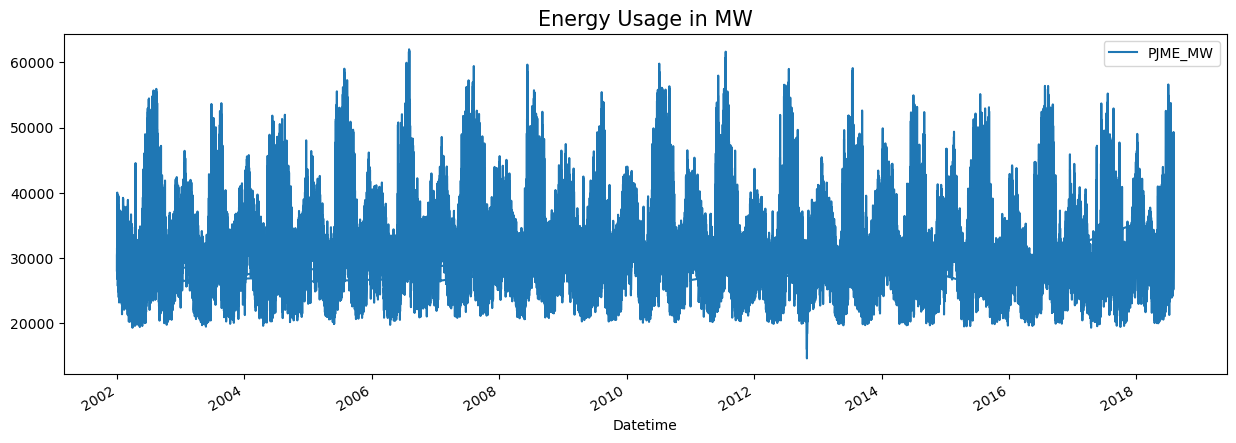

In [83]:
df.plot(figsize=(15,5))
plt.title("Energy Usage in MW", fontsize=15)
plt.show()

## Feature engineering

**Crearing new inputs from raw data**

In [84]:
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df.head()

,PJME_MW,month,day,hour,day_of_week
Datetime,,,,,
2002-12-31 01:00:00,26498.0,12,31,1,1
2002-12-31 02:00:00,25147.0,12,31,2,1
2002-12-31 03:00:00,24574.0,12,31,3,1
2002-12-31 04:00:00,24393.0,12,31,4,1
2002-12-31 05:00:00,24860.0,12,31,5,1
